In [1]:
run ct_include.ipy

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy

sns.set()

sns.set_context("poster")
plt.rcParams["figure.figsize"] = [14,6]

In [3]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>The raw code for this Jupyter notebook is hidden for easier reading.
To toggle on/off the input code, click <a href="javascript:code_toggle()">here</a>.</b>''')

# <center>GG2 Simulator Demo</center>
### <center>Ed Phillips, Dom Kirkham, Bruno Mlodozeniec</center>
---
---

The figure below shows that according to equation 1, where $log(I) \propto -\mu x$, $\mu$ is only constant with depth for an ideal source. This is due to the fact that ideal sources do not experience beam hardening.

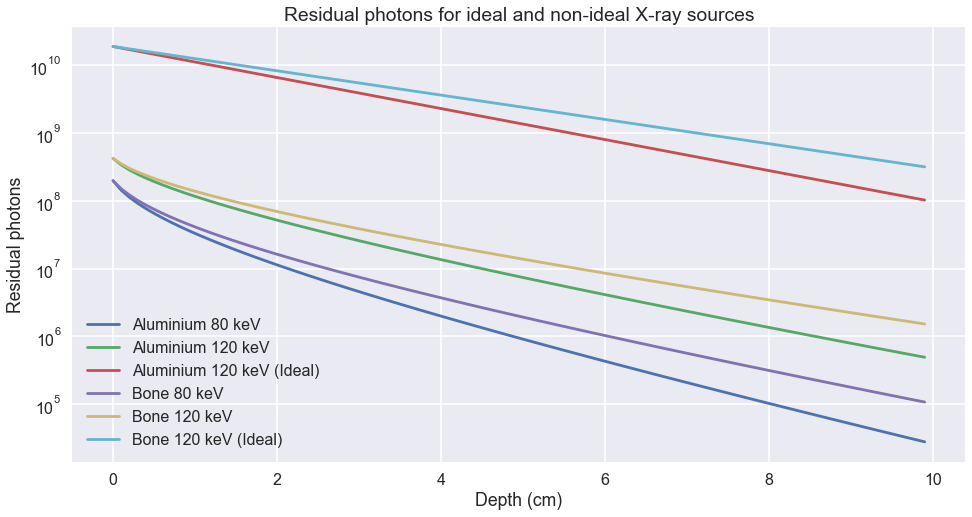

In [5]:
fig2, ax2 = plt.subplots()
fig2.set_size_inches(16,8)

test_materials = ["Aluminium", "Bone"]

ideal_source = fake_source(material_data.mev, 0.12, material_data.coeff("Aluminium"), 1, method='ideal')
nonideal_source = fake_source(material_data.mev, 0.12, material_data.coeff("Aluminium"), 1)
nonideal_source_low = fake_source(material_data.mev, 0.08, material_data.coeff("Aluminium"), 1)

for mat in test_materials:
    atten_energies_ideal = ct_detect(ideal_source, material_data.coeff(mat), np.arange(0, 10.0, 0.1), 1)
    atten_energies = ct_detect(nonideal_source, material_data.coeff(mat), np.arange(0, 10.0, 0.1), 1)
    atten_energies_low = ct_detect(nonideal_source_low, material_data.coeff(mat), np.arange(0, 10.0, 0.1), 1)
    
    ax2.plot(np.arange(0,10.0,0.1), atten_energies_low, label=mat+" 80 keV")
    ax2.plot(np.arange(0,10.0,0.1), atten_energies, label=mat+" 120 keV")
    ax2.plot(np.arange(0,10.0,0.1), atten_energies_ideal, label=mat+" 120 keV (Ideal)")
    
ax2.legend()
ax2.set_xlabel("Depth (cm)")
ax2.set_ylabel(r"Residual photons")
ax2.set_yscale('log')
ax2.set_title("Residual photons for ideal and non-ideal X-ray sources");

In the function ```ct_calibrate.py```, we calculate our total attenuation by assuming that $\mu$ does not vary with photon energy. This approximation is accurate for the ideal source, where there is only a single/very small range of values of $\mu$, however for a non-ideal source, this approximation-and the fact that the reconstruction doesn't account for beam hardening-begin to introduce error. These can be seen in the figures below. 

In [63]:
scale = 0.1
angles = 512

point_phantom = ct_phantom(material_data.names, 256, 2, 'Titanium')
circle_phantom = ct_phantom(material_data.names, 256, 1, 'Titanium')
hip_phantom = ct_phantom(material_data.names, 256, 3, 'Titanium')
phantoms = [point_phantom, circle_phantom, hip_phantom]

no_pixels = [128,256,512]
pixel_phantoms = list(map(lambda pixels: ct_phantom(material_data.names, pixels, 3, "Titanium"), no_pixels))

sinograms_ideal = list(map(
    lambda phantom: ct_calibrate(ideal_source, material_data, ct_scan(ideal_source, material_data, phantom, scale, angles, interpolation_order=1), scale),
    phantoms));

sinograms_nonideal = list(map(
    lambda phantom: ct_calibrate(nonideal_source, material_data, ct_scan(nonideal_source, material_data, phantom, scale, angles, interpolation_order=1), scale),
    phantoms));

sinograms_pixels = list(map(
    lambda phantom: ct_calibrate(ideal_source, material_data, ct_scan(ideal_source, material_data, phantom, scale*256/max(phantom.shape), angles, interpolation_order=1), scale),
    pixel_phantoms));

Scanning angle: 512   
Scanning angle: 512   
Scanning angle: 512   
Scanning angle: 512   
Scanning angle: 512   
Scanning angle: 512   
Scanning angle: 512   
Scanning angle: 512   
Scanning angle: 512   


In [64]:
reconstructions_ideal = list(map(
    lambda phantom: scan_and_reconstruct(ideal_source, material_data, phantom, scale, angles),
    phantoms));

reconstructions_nonideal = list(map(
    lambda phantom: scan_and_reconstruct(nonideal_source, material_data, phantom, scale, angles),
    phantoms));

reconstructions_pixels = list(map(
    lambda phantom: scan_and_reconstruct(ideal_source, material_data, phantom, scale, angles),
    pixel_phantoms));

Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   
Scanning angle: 512   
Ramp filtering...
Reconstructing angle: 512   


Text(0.5, -0.02, 'Phantom, calibrated sinogram and the computed reconstruction for three phantoms. Calculated for num. angles: 512 and scale: 0.1cm')

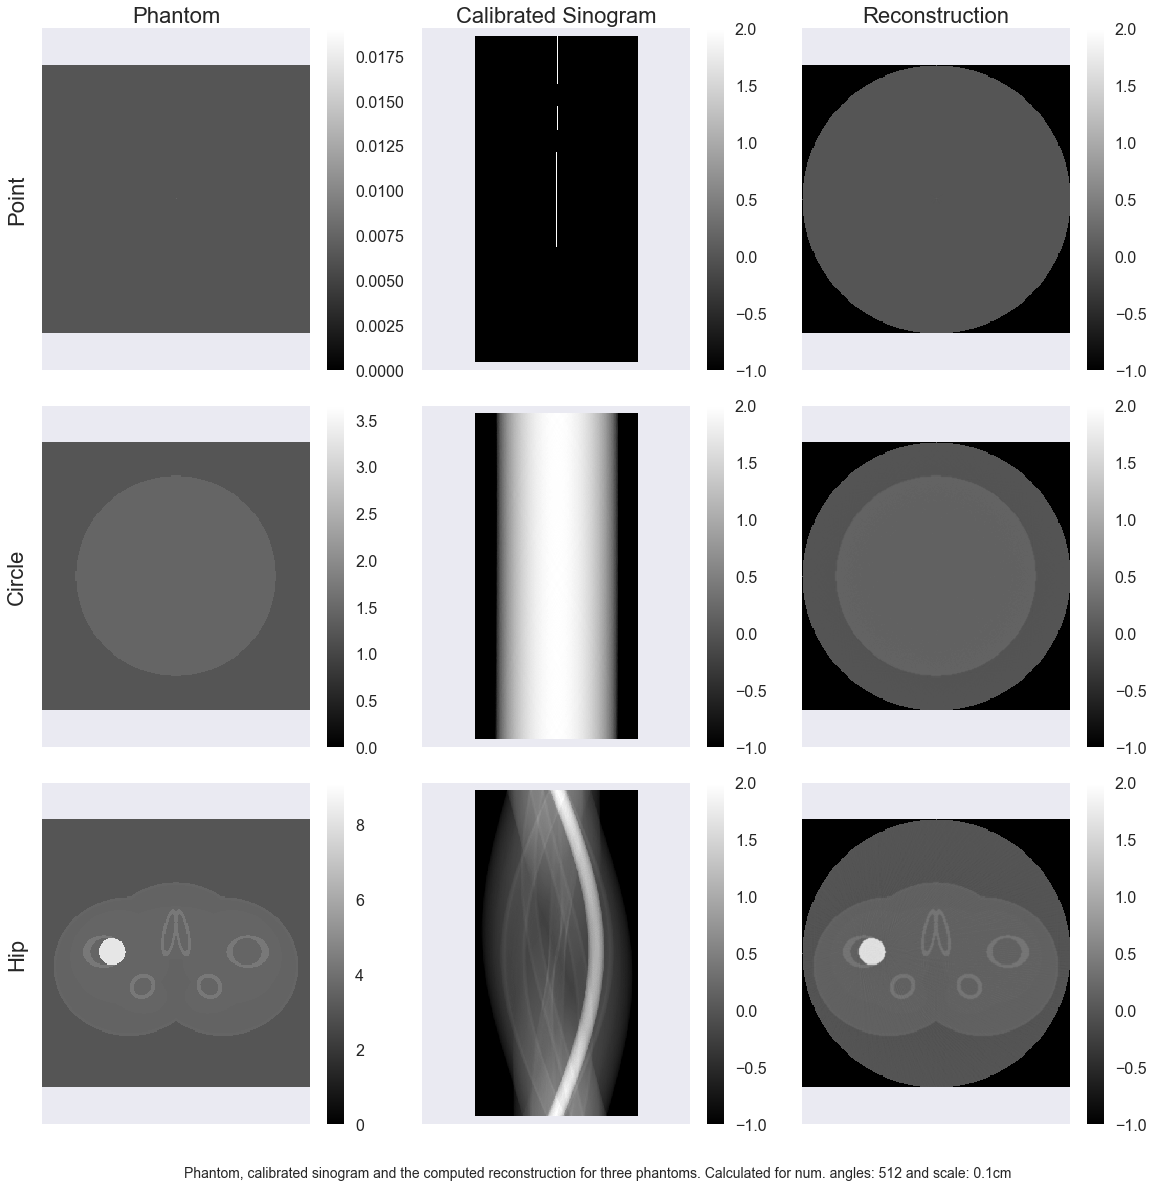

In [65]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(16,16)

point_phantom = np.array(point_phantom, dtype="int")
circle_phantom = np.array(circle_phantom, dtype="int")
hip_phantom = np.array(hip_phantom, dtype="int")

new_phantoms = copy.deepcopy(phantoms)

for i, phantom in enumerate(new_phantoms):
    for j, row in enumerate(phantom):
        for k, val in enumerate(row):
            new_phantoms[i][j][k] = np.dot(material_data.coeffs[int(val)], ideal_source)/np.sum(ideal_source)
            

for i, phantom, sinogram, recon in zip(range(3), new_phantoms, sinograms_ideal, reconstructions_ideal):
    ax_phantom = ax[i,0]
    ax_sinogram = ax[i,1]
    ax_recon = ax[i,2]
    
    phan = ax_phantom.imshow(phantom, cmap='gray', vmin=-1, vmax=2)
    sino = ax_sinogram.imshow(sinogram, cmap='gray')
    im = ax_recon.imshow(recon, cmap='gray', vmin=-1, vmax=2)
    fig.colorbar(im, ax=ax[i,2])
    fig.colorbar(phan, ax=ax[i,1])
    fig.colorbar(sino, ax=ax[i,0])
    
    for j in range(3):
        ax[i, j].grid(False)
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_aspect('equal', 'datalim')
plt.tight_layout()
for i, phantom_name in enumerate(['Point', 'Circle', 'Hip']):
    ax[i, 0].set_ylabel(phantom_name, fontsize=22)

for i, plot_name in enumerate(['Phantom', 'Calibrated Sinogram', 'Reconstruction']):
    ax[0,i].set_title(plot_name, fontsize=22)

# Caption
plt.figtext(0.5, -0.02, "Phantom, calibrated sinogram and the computed reconstruction for three phantoms. "
         "Calculated for num. angles: 512 and scale: 0.1cm", wrap=True, horizontalalignment='center', fontsize=14)

### Reconstruction error for non-ideal 120keV source

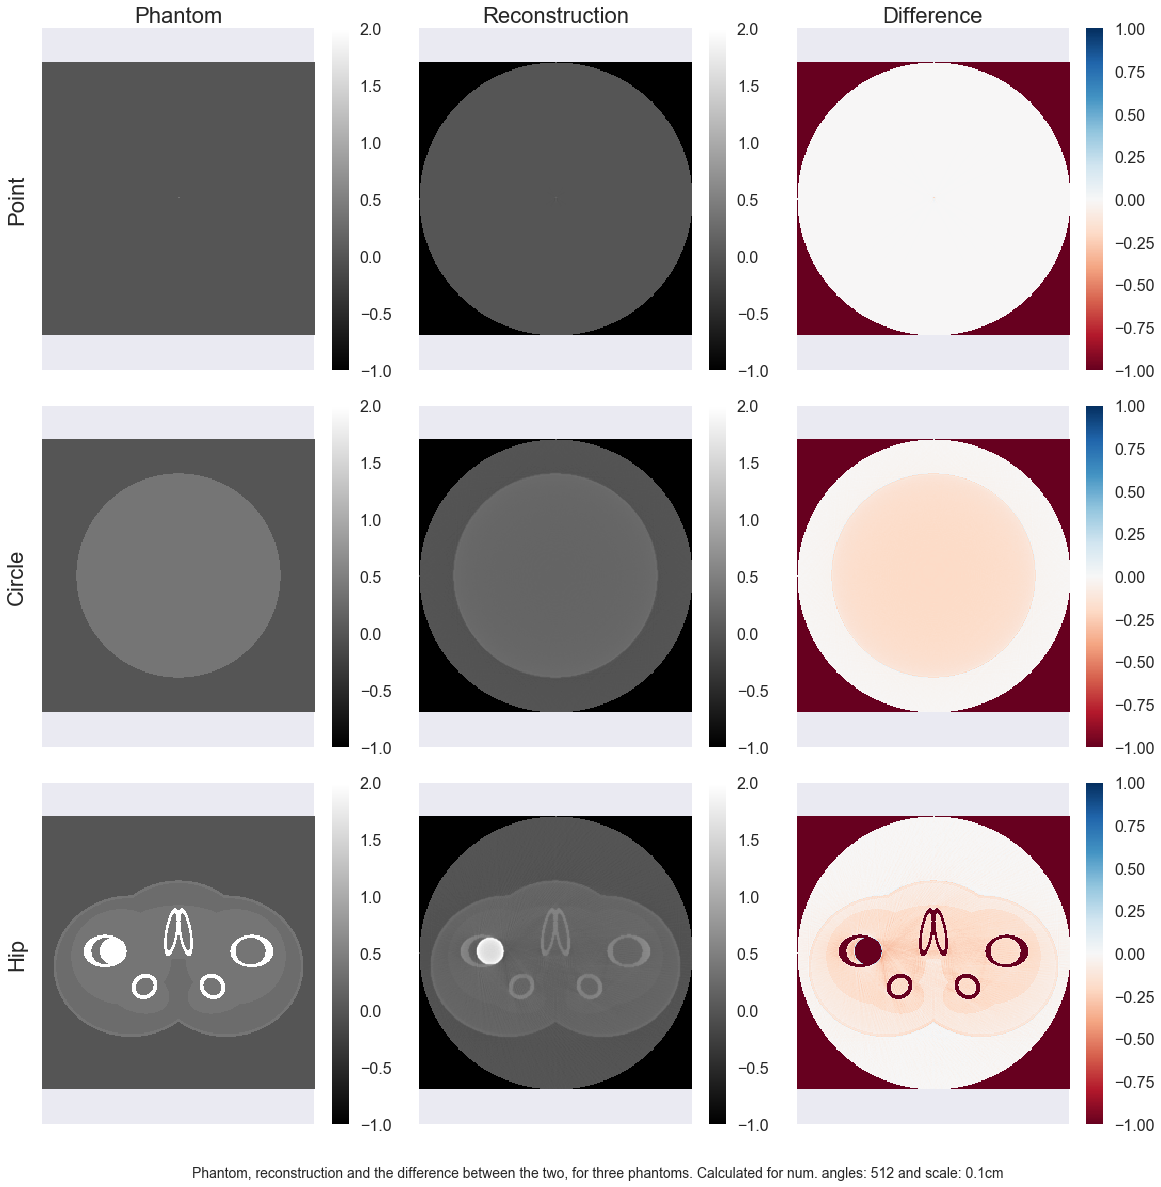

In [66]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(16,16)

new_phantoms_nonideal = copy.deepcopy(phantoms)

for i, phantom in enumerate(new_phantoms_nonideal):
    for j, row in enumerate(phantom):
        for k, val in enumerate(row):
            new_phantoms_nonideal[i][j][k] = np.dot(material_data.coeffs[int(val)], nonideal_source)/np.sum(nonideal_source)

for i, phantom, sinogram, recon in zip(range(3), new_phantoms_nonideal, sinograms_nonideal, reconstructions_nonideal):

    ax_phantom = ax[i,0]
    ax_recon = ax[i,1]
    ax_error = ax[i,2]
    
    # recon_norm = (recon - np.amin(recon))/ (np.amax(recon)-np.amin(recon))
    # phantom_norm = (phantom - np.amin(phantom))/ (np.amax(phantom)-np.amin(phantom))
    
    im2 = ax_phantom.imshow(phantom, cmap='gray', vmin=-1, vmax=2)
    im1 = ax_error.imshow(recon-phantom, cmap='RdBu', vmin=-1, vmax=1)
    ax_recon.imshow(recon, cmap='gray', vmin=-1, vmax=2)
    fig.colorbar(im1, ax=ax[i,2])
    fig.colorbar(im2, ax=ax[i,0])
    fig.colorbar(im2, ax=ax[i,1])
    for j in range(3):
        ax[i, j].grid(False)
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_aspect('equal', 'datalim')
plt.tight_layout()
for i, phantom_name in enumerate(['Point', 'Circle', 'Hip']):
    ax[i, 0].set_ylabel(phantom_name, fontsize=22)

for i, plot_name in enumerate(['Phantom', 'Reconstruction', 'Difference']):
    ax[0,i].set_title(plot_name, fontsize=22)

# Caption
plt.figtext(0.5, -0.02, "Phantom, reconstruction and the difference between the two, for three phantoms. "
         "Calculated for num. angles: 512 and scale: 0.1cm", wrap=True, horizontalalignment='center', fontsize=14);

In the figure above, we can see that the reconstructed attenuation values are almost exactly the same as those expected from the original phantom. The only small errors are around the borders of an object, and the error is greater for smaller objects. This is likely due to the inaccuracies of the linear interpolation used here, either in the sinogram or in the backprojection. 

### Reconstruction error for ideal 120keVp source

Text(0.5, -0.02, 'Phantom, reconstruction and the difference between the two, for three phantoms.Calculated for num. angles: 512 and scale: 0.1cm')

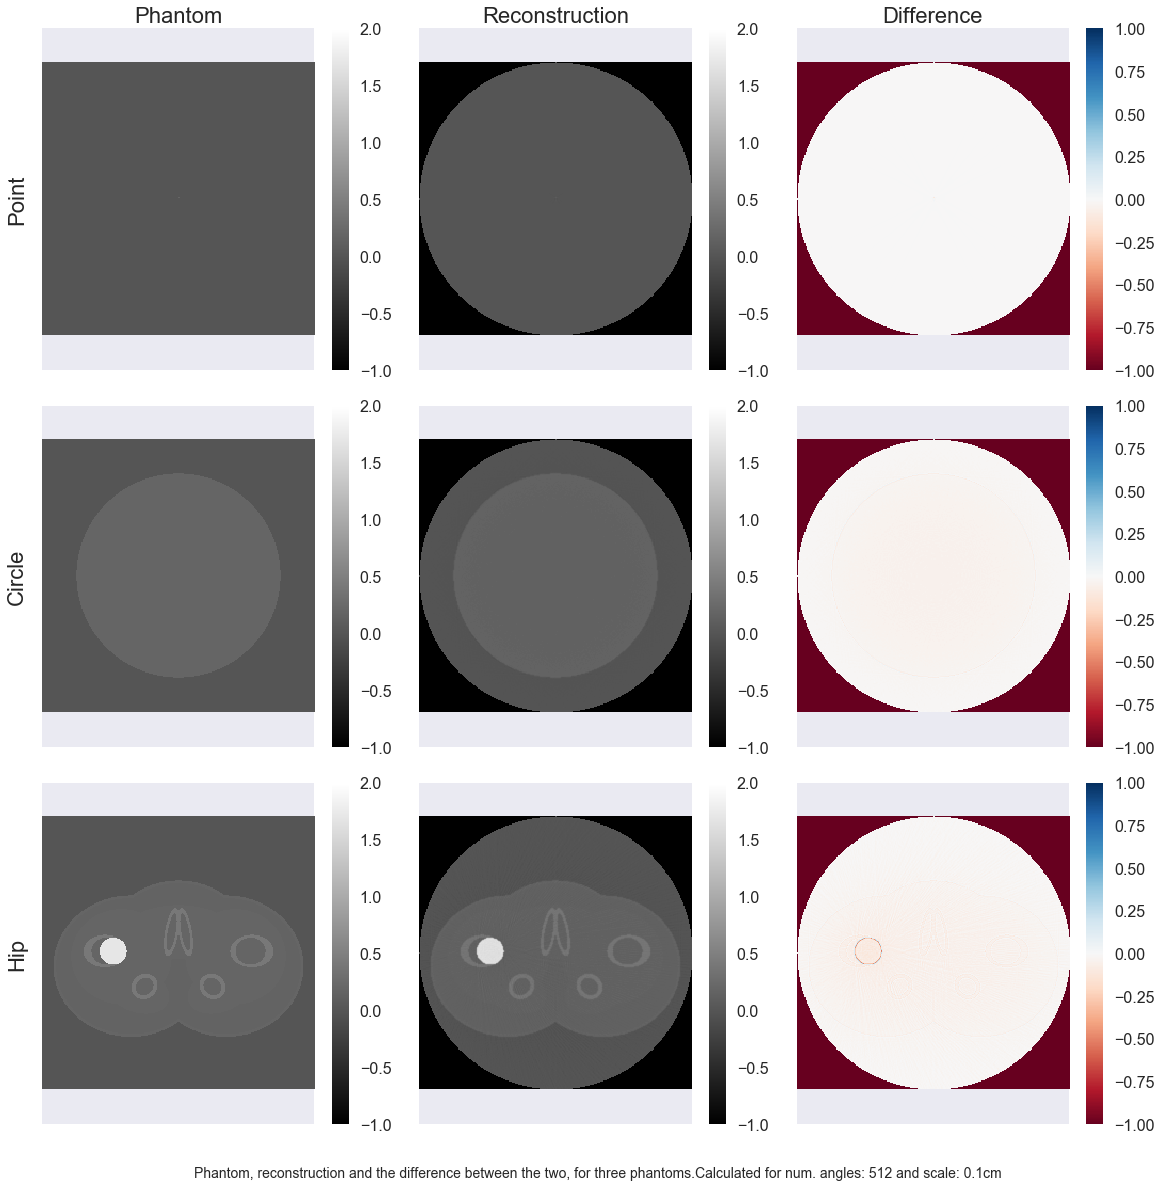

In [67]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(16,16)

new_phantoms_ideal = copy.deepcopy(phantoms)

for i, phantom in enumerate(new_phantoms_ideal):
    for j, row in enumerate(phantom):
        for k, val in enumerate(row):
            new_phantoms_ideal[i][j][k] = np.dot(material_data.coeffs[int(val)], ideal_source)/np.sum(ideal_source)

for i, phantom, sinogram, recon in zip(range(3), new_phantoms_ideal, sinograms_ideal, reconstructions_ideal):

    ax_phantom = ax[i,0]
    ax_recon = ax[i,1]
    ax_error = ax[i,2]
    
    # recon_norm = (recon - np.amin(recon))/ (np.amax(recon)-np.amin(recon))
    # phantom_norm = (phantom - np.amin(phantom))/ (np.amax(phantom)-np.amin(phantom))
    
    im2 = ax_phantom.imshow(phantom, cmap='gray', vmin=-1, vmax=2)
    im1 = ax_error.imshow(recon-phantom, cmap='RdBu', vmin=-1, vmax=1)
    ax_recon.imshow(recon, cmap='gray', vmin=-1, vmax=2)
    fig.colorbar(im1, ax=ax[i,2])
    fig.colorbar(im2, ax=ax[i,0])
    fig.colorbar(im2, ax=ax[i,1])
    for j in range(3):
        ax[i, j].grid(False)
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_aspect('equal', 'datalim')
plt.tight_layout()
for i, phantom_name in enumerate(['Point', 'Circle', 'Hip']):
    ax[i, 0].set_ylabel(phantom_name, fontsize=22)

for i, plot_name in enumerate(['Phantom', 'Reconstruction', 'Difference']):
    ax[0,i].set_title(plot_name, fontsize=22)

# Caption
plt.figtext(0.5, -0.02, "Phantom, reconstruction and the difference between the two, for three phantoms."
         "Calculated for num. angles: 512 and scale: 0.1cm", wrap=True, horizontalalignment='center', fontsize=14)

### Reconstruction error for varying phantom size

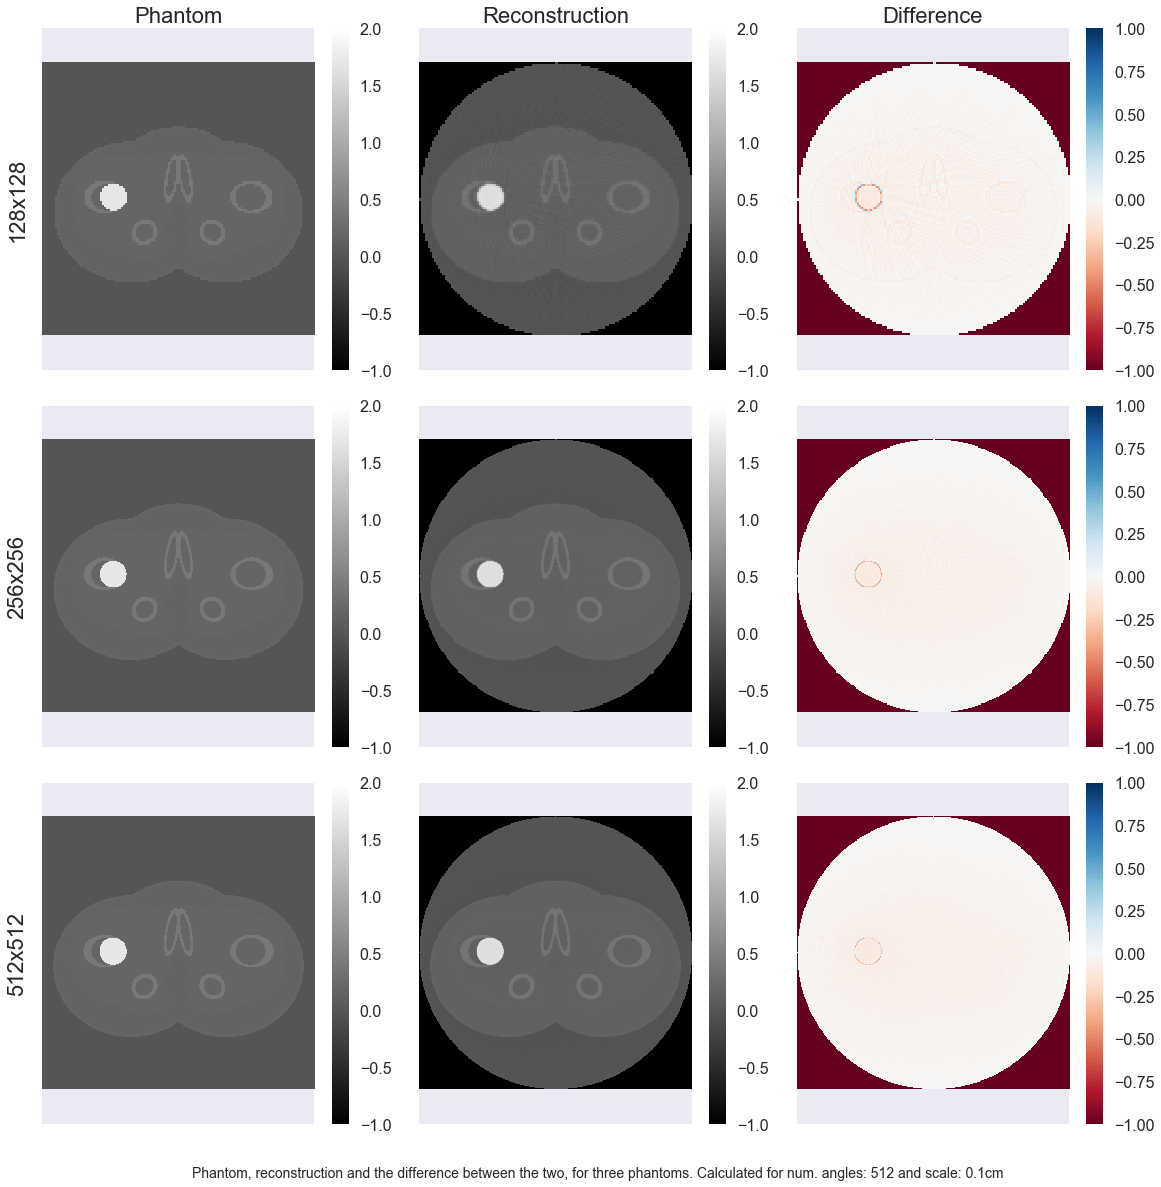

In [68]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(16,16)

new_phantoms_pixels = copy.deepcopy(pixel_phantoms)

for i, phantom in enumerate(new_phantoms_pixels):
    for j, row in enumerate(phantom):
        for k, val in enumerate(row):
            new_phantoms_pixels[i][j][k] = np.dot(material_data.coeffs[int(val)], ideal_source)/np.sum(ideal_source)

for i, phantom, sinogram, recon in zip(range(3), new_phantoms_pixels, sinograms_pixels, reconstructions_pixels):

    ax_phantom = ax[i,0]
    ax_recon = ax[i,1]
    ax_error = ax[i,2]
    
    im1 = ax_phantom.imshow(phantom, cmap='gray', vmin=-1, vmax=2)
    im3 = ax_error.imshow(recon-phantom, cmap='RdBu', vmin=-1, vmax=1)
    im2 = ax_recon.imshow(recon, cmap='gray', vmin=-1, vmax=2)
    fig.colorbar(im1, ax=ax[i,0])
    fig.colorbar(im2, ax=ax[i,1])
    fig.colorbar(im3, ax=ax[i,2])
    for j in range(3):
        ax[i, j].grid(False)
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_aspect('equal', 'datalim')
plt.tight_layout()
for i, phantom_name in enumerate(['128x128', '256x256', '512x512']):
    ax[i, 0].set_ylabel(phantom_name, fontsize=22)

for i, plot_name in enumerate(['Phantom', 'Reconstruction', 'Difference']):
    ax[0,i].set_title(plot_name, fontsize=22)

# Caption
plt.figtext(0.5, -0.02, "Phantom, reconstruction and the difference between the two, for three phantoms. "
         "Calculated for num. angles: 512 and scale: 0.1cm", wrap=True, horizontalalignment='center', fontsize=14);

Above shows the reconstruction errors as the size of the phantom is increased, for 512 scanning angles. The error around the titanium hip replacement becomes smaller as the size of the phantom is increased, suggesting that the error is due to interpolation

## Reconstruction Progression

![SegmentLocal](scan_demo.gif "segment")

The above is an animation of the reconstruction happening live as more and more angles have been back-projected.